In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import datetime

# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'MFO'

/mnt/e/ML/cafa-5-protein-function-prediction


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)


In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(670114, 3)


In [5]:
testID = df.index.to_list()[0]

## GO analysis

In [6]:
item_counts = df["term"].value_counts()

In [7]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [8]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]

dfGo.set_index("term", inplace=True)

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [9]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()

#TODO: Change the order of label weights in all the other models!!
# it should be 'for go in mlb.classes_' 

notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [10]:
topGOs=item_counts.index.to_list()

threshold=0
labelWeights=np.array(labelWeights)
selection = labelWeights>threshold
topGOs=np.array(topGOs)[selection]

if os.path.exists(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy")):
    print("Loading presaved data")
    GODataSizes = np.load(os.path.join(DATA_PATH, "GODataSizes_"+SO+".npy"))
else:
    GODataSizes= [dfGo.loc[g].size for g in topGOs]
    np.save(os.path.join(DATA_PATH, "GODataSizes_"+SO), GODataSizes)


Loading presaved data


In [11]:
#At least 10 samples
print(np.count_nonzero(np.array(GODataSizes)>20))
GODataSizes= np.array(GODataSizes)
GOsWithSufficientData = topGOs[GODataSizes>20]


2099


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle


mlb = MultiLabelBinarizer()
mlb.fit([GOsWithSufficientData])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0003674' 'GO:0003953' 'GO:0016787' 'GO:0016799' 'GO:0016798'
 'GO:0003824']
[[0 0 0 ... 0 0 0]]
2099


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['GO:0003674'] will be ignored
  warnings.warn(


In [13]:

labelWeightsCorr=[]

notFound=0
for go in mlb.classes_:
    if go in allIndices:
        labelWeightsCorr.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeightsCorr.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))
labelWeightsCorr=np.array(labelWeightsCorr)

Not found GOs: 0 (set to 0)


## Amino acids encoding

In [14]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [15]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [16]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

# SoSequences = []
# for entry in soEntryIds:
#     SoSequences.append(sequences[ids.index(entry)])

# print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A023FBW4' 'A0A023FBW7' ... 'X5L1L5' 'X5L565' 'X5M5N0']


In [17]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]

        

99572


## One-vs-Rest Classification

In [18]:
target = mlb.classes_[671]

def getKmers(seq):
    kmers = [seq[j:j+k] if j < len(seq)-(k-1) else 0 for j,el in enumerate(seq)]
    kmers = kmers[0:-(k-1)]
    kmers = [str(el) for el in kmers]
    values, counts = np.unique(kmers, return_counts=True)
    freqVector=np.zeros(allCombinations.shape)
    for l,v in enumerate(values):
        freqVector[positionDict[v]] = counts[l]
    return freqVector


X=[]
y=[]
positiveClassCount=0

for i,seq in enumerate(tqdm(trainSeq)):
    entryId = trainIds[i]
    if entryId in soEntryIds:
        labelData = df.loc[entryId]
        indices = labelData["term"].to_numpy()
    else: 
        indices=[]
    if target in indices:
        freqVector= getKmers(seq)
        X.append(freqVector)
        y.append(1)
        positiveClassCount += 1
    elif 0.2*len(y) < positiveClassCount:
        freqVector= getKmers(seq)
        X.append(freqVector)
        y.append(0)
    else:
        continue

X=np.array(X)
y=np.array(y)

    

100%|██████████| 99572/99572 [01:20<00:00, 1231.62it/s]


In [19]:

Xval=[]
yval=[]
positiveClassCountVal=0
for i,seq in enumerate(tqdm(valSeq)):
    entryId = valIds[i]
    if entryId in soEntryIds:
        labelData = df.loc[entryId]
        indices = labelData["term"].to_numpy()
    else: 
        indices=[]
    if target in indices:
        freqVector= getKmers(seq)
        Xval.append(freqVector)
        yval.append(1)
        positiveClassCountVal += 1
    elif len(yval)/2 < positiveClassCountVal:
        freqVector= getKmers(seq)
        Xval.append(freqVector)
        yval.append(0)
    else:
        continue

Xval=np.array(Xval)
yval=np.array(yval)

100%|██████████| 42673/42673 [00:34<00:00, 1240.79it/s]


In [20]:
print(X.shape)
print(y.shape)
print(np.count_nonzero(y))
print(Xval.shape)
print(yval.shape)
print(np.count_nonzero(yval))

(140, 15625)
(140,)
28
(16, 15625)
(16,)
8


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier

# clf = LogisticRegression().fit(X, y)
# clf = svm.SVC(probability=True).fit(X, y)
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 64)).fit(X, y)
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver="liblinear"))
# clf = make_pipeline(preprocessing.StandardScaler(), AdaBoostClassifier(n_estimators=50))
# clf = make_pipeline(preprocessing.StandardScaler(), MLPClassifier(solver='lbfgs', random_state=854, hidden_layer_sizes=(32,32,32)))

clf.fit(X, y)
# print(clf.predict(Xval))
# print(clf.predict_proba(Xval))
print(clf.score(Xval, yval))

0.75


In [22]:
def ClassificationScores(yTrue, yPred):
    tp = np.sum(np.logical_and(np.array(yTrue, dtype="bool") , np.array(yPred, dtype="bool")))
    fn = np.sum(np.logical_and(np.logical_not(yTrue) , np.array(yPred, dtype="bool")))
    fp = np.sum(np.logical_and(np.array(yTrue, dtype="bool") , np.logical_not(yPred)))
    prec = (tp)/(tp+fp+1e-20)
    rec = tp/(tp+fn+1e-20)
    f1 = 2*(prec*rec)/(prec+rec+1e-20)
    return prec, rec, f1

In [23]:
ClassificationScores(yval, clf.predict(Xval))

(0.875, 0.7, 0.7777777777777777)

----

In [24]:
dfGo = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfGo = dfGo.loc[dfGo["aspect"]==SO]
uniqueTerms = dfGo["term"].unique()
termsArr = list(dfGo["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfGo.shape)

dfGo.set_index("term", inplace=True)

(670114, 3)


In [25]:
seqDict = dict(zip(ids, sequences))
classifiers = []
scores=[]
f1Scores=[]
failedClasses=[]
XSizes=[]

for l in tqdm(mlb.classes_, smoothing=0.1):
    X=[]
    y=[]
    # if dfGo.loc[l].size<3:
    #     classifiers.append(None)
    #     f1Scores.append(0)
    #     scores.append(0)
    #     failedClasses.append({"class": l, "reason": "data"})
    #     continue

    relevantSequenceIds = dfGo.loc[l]["EntryID"].unique()
    for seqId in relevantSequenceIds:
        seq = seqDict[seqId]
        X.append(getKmers(seq))
        y.append(1)
        if(len(y)>200):
            break

    nonRelSeqIds = dfGo.sample(n=len(X))["EntryID"].unique()
    for seqId in nonRelSeqIds:
        if seqId in relevantSequenceIds:
            continue
        seq = seqDict[seqId]
        X.append(getKmers(seq))
        y.append(0)
    
    XSizes.append(len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    try:
        # clf = make_pipeline(preprocessing.StandardScaler(), MLPClassifier(solver='lbfgs', random_state=854, hidden_layer_sizes=(32,32,32)))
        clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver="liblinear"))
        clf = clf.fit(X_train, y_train)
    except Exception as err:
        classifiers.append(None)
        f1Scores.append(0)
        scores.append(0)
        failedClasses.append({"class": l, "reason": err})
    else:
        classifiers.append(clf)
        f1Scores.append(ClassificationScores(y_test, clf.predict(X_test)))
        # print(clf.predict_proba(Xval))
        scores.append(clf.score(X_test, y_test))



100%|██████████| 2099/2099 [08:45<00:00,  4.00it/s]


In [26]:
with open(os.path.join(DATA_PATH,"ClassifierArray_"+SO+".bin"), "wb") as f: 
    pickle.dump(classifiers, f)

(array([  2.,   8.,  22.,  27.,  73., 167., 388., 406., 537., 469.]),
 array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
        0.825 , 0.9125, 1.    ]),
 <BarContainer object of 10 artists>)

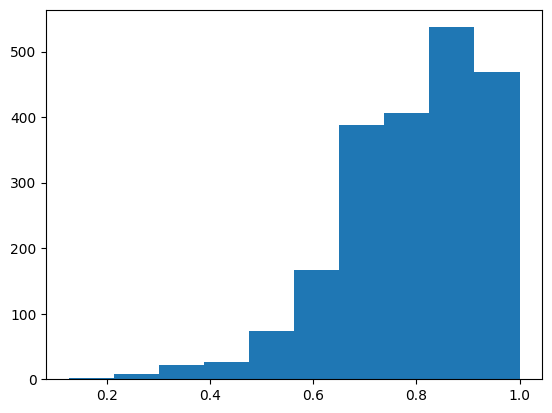

In [26]:
import matplotlib.pyplot as plt
plt.hist(scores)

In [27]:
precisionValues = [el[0] if isinstance(el, tuple) else 0 for el in f1Scores]
recValues = [el[1] if isinstance(el, tuple) else 0 for el in f1Scores]
f1Values = [el[2] if isinstance(el, tuple) else 0 for el in f1Scores]

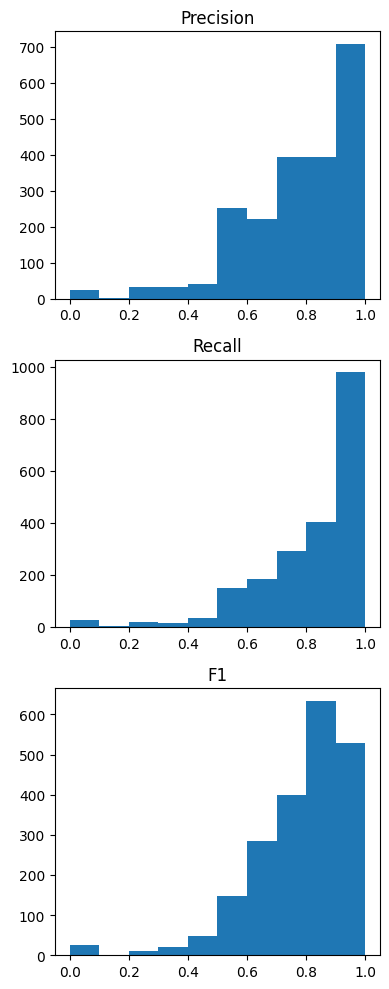

In [31]:
plt.figure(figsize=(4,10))
plt.subplot(3,1,1)
plt.hist(precisionValues)
plt.title("Precision")
plt.subplot(3,1,2)
plt.hist(recValues)
plt.title("Recall")
plt.subplot(3,1,3)
plt.hist(f1Values)
plt.title("F1")
plt.tight_layout()

In [30]:
np.sum(labelWeightsCorr*f1Values)/np.sum(labelWeightsCorr)

0.7653588106846742

----

In [31]:
np.unique([el["reason"] for el in failedClasses], return_counts=True)

(array([], dtype=float64), array([], dtype=int64))

In [32]:
testDf = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')
testDf.loc[testDf["term"]==failedClasses[0]["class"]]

IndexError: list index out of range

1361 of the 1667 classes with score<0.1 have just one single sequence assigned. It is just not possible to fit any classifier to that besides maybe a knn approach